In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- Configuration ---
OUTPUT_DIR = "./result_new"  # Or your actual path


# TARGET_ACCURACY_COC = 0.8 # Not used in Gini/Selection plots, but good to have if other plots use it

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy()  # Return a copy even if empty

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique_vals_str = list(map(str, processed_df[col].unique()))  # For robust printing
                if verbose: print(f"Column '{col}' before mapping. Unique values (as str): {original_unique_vals_str}")
                # Handle NaN mapping first if present in keys
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                        processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else:  # No specific NaN mapping, just replace
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. New unique values: {processed_df[col].unique()}")
            elif verbose:
                print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns:  # Check if column exists BEFORE trying to process
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()
                if verbose and coerced_nan_count > original_nan_count:
                    print(
                        f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric (were {original_nan_count}).")

                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose:
                print(f"Warning: Column '{col}' (listed in FLOAT_PRECISIONS) not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0.0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique():  # Check if 'No Attack' exists after mapping
            # Ensure ADV_RATE is numeric before this assignment
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')

            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose:
            print("'No Attack' not found in ATTACK_METHOD after mapping; ADV_RATE for 'No Attack' not set to 0.")

    return processed_df


# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1,
    'discovery_quality': 1,
    'FINAL_MAIN_ACC': 4,
    'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_BENIGN_PAYMENT_GINI': 3,  # Assuming this is AVG_BENIGN_PAYMENT_GINI from your CSV
    'AVG_ADVERSARY_SELECTION_RATE': 3,  # This is the proportion of *selected* clients that are adversaries
    'AVG_BENIGN_SELLER_SELECTION_RATE': 3,  # This might be rate among available benign, or proportion of selected
    'AVG_COST_PER_ROUND': 2,  # Overall average cost per round
    'COST_OF_CONVERGENCE': 0,  # Assuming integer rounds/costs
    'TOTAL_COST': 0,  # Assuming integer rounds/costs
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4': 3,
    # Add derived columns here if you want them rounded by the helper,
    # otherwise, round them after derivation.
    'AVG_COST_PER_ROUND_BENIGN': 2,
    'AVG_COST_PER_ROUND_MALICIOUS': 2
}

CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {
        'single': 'Backdoor',
        np.nan: 'No Attack',  # Handles empty cells in CSV read as pandas NaN
        'None': 'No Attack',  # Handles cells with string 'None'
        'no_attack': 'No Attack'  # Handles cells with string 'no_attack'
    },
    'IS_SYBIL': {
        # Assuming your CSV has string 'False' and string 'mimic'
        # If it's boolean True/False, you'd map them:
        # True: 'mimic', 
        # False: 'False' # Keep 'False' as string 'False' for consistency
    }
}

# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame()  # Initialize as empty

try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(
        summary_df_avg_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS,
        verbose=True  # Enable verbose output for debugging
    )

    # --- DERIVE COST COMPOSITION COLUMNS (Benign vs. Malicious Cost per Round) ---
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'

    # Check if derivation is sensible (i.e., source columns exist)
    if 'AVG_COST_PER_ROUND' in summary_df_avg.columns and \
            'AVG_ADVERSARY_SELECTION_RATE' in summary_df_avg.columns:

        print("Deriving cost composition (benign/malicious) from AVG_COST_PER_ROUND and AVG_ADVERSARY_SELECTION_RATE.")

        # Ensure source columns are numeric (they should be after preprocess_experiment_data if listed in FLOAT_PRECISIONS)
        # If not listed, convert them here explicitly before use.
        for col_to_check in ['AVG_COST_PER_ROUND', 'AVG_ADVERSARY_SELECTION_RATE']:
            if col_to_check not in FLOAT_PRECISIONS:  # If not already processed by helper
                if col_to_check in summary_df_avg.columns:
                    summary_df_avg[col_to_check] = pd.to_numeric(summary_df_avg[col_to_check], errors='coerce')
                    print(f"  Ensured column '{col_to_check}' is numeric for derivation.")
                else:
                    print(f"  Warning: Source column '{col_to_check}' for derivation not found.")
                    # Create empty columns to prevent later key errors if derivation fails
                    summary_df_avg[cost_mal_col] = np.nan
                    summary_df_avg[cost_benign_col] = np.nan

        # For "No Attack" runs, AVG_ADVERSARY_SELECTION_RATE should be 0 for this calculation.
        # The preprocess_experiment_data sets ADV_RATE to 0.
        # Your data generation script should ensure AVG_ADVERSARY_SELECTION_RATE is 0 for No Attack runs.
        # If it might be NaN for No Attack runs, fill it with 0 before calculation.
        adv_sel_rate_for_calc = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].copy()
        # If ATTACK_METHOD is 'No Attack', this rate is definitionally 0.
        # Also, if it's NaN for an attack run (shouldn't happen if data is good), treat as 0 for safety here.
        adv_sel_rate_for_calc[summary_df_avg['ATTACK_METHOD'] == 'No Attack'] = 0.0
        adv_sel_rate_for_calc.fillna(0.0, inplace=True)  # Fill any other NaNs with 0 to avoid NaN propagation

        # Calculate derived costs
        summary_df_avg[cost_mal_col] = summary_df_avg['AVG_COST_PER_ROUND'] * adv_sel_rate_for_calc
        summary_df_avg[cost_benign_col] = summary_df_avg['AVG_COST_PER_ROUND'] * (1 - adv_sel_rate_for_calc)

        # Round the newly derived columns if they weren't already in FLOAT_PRECISIONS
        # or if derivation might have introduced new float precision issues.
        if cost_mal_col in summary_df_avg.columns:
            summary_df_avg[cost_mal_col] = summary_df_avg[cost_mal_col].round(FLOAT_PRECISIONS.get(cost_mal_col, 2))
        if cost_benign_col in summary_df_avg.columns:
            summary_df_avg[cost_benign_col] = summary_df_avg[cost_benign_col].round(
                FLOAT_PRECISIONS.get(cost_benign_col, 2))
        print("Derived and processed cost composition columns.")

    else:
        print(
            "Warning: Cannot derive cost composition. Missing 'AVG_COST_PER_ROUND' or 'AVG_ADVERSARY_SELECTION_RATE'.")
        # Ensure columns exist as NaN if derivation fails, for consistency in later plotting cells
        if cost_mal_col not in summary_df_avg.columns: summary_df_avg[cost_mal_col] = np.nan
        if cost_benign_col not in summary_df_avg.columns: summary_df_avg[cost_benign_col] = np.nan

    print(f"Processed summary_df_avg shape: {summary_df_avg.shape}")
    if not summary_df_avg.empty:
        print("\nFirst 5 rows of processed summary_df_avg (after potential derivation):")
        display(summary_df_avg.head())
        print("\nInfo of processed summary_df_avg:")
        summary_df_avg.info()

except FileNotFoundError:
    print(f"CRITICAL ERROR: summary_avg.csv not found in {OUTPUT_DIR}. Cannot proceed with plotting.")
    summary_df_avg = pd.DataFrame()  # Ensure it's an empty DF if load fails
except Exception as e:
    print(f"CRITICAL ERROR: An error occurred during summary_df_avg loading or preprocessing: {e}")
    summary_df_avg = pd.DataFrame()

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
try:
    all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")
    print("\nall_rounds.csv loaded successfully.")
    all_rounds_df = preprocess_experiment_data(
        all_rounds_df_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS
    )
    print(f"Processed all_rounds_df shape: {all_rounds_df.shape}")
    if not all_rounds_df.empty: display(all_rounds_df.head())
except FileNotFoundError:
    print(f"Error: all_rounds.csv not found in {OUTPUT_DIR}. Please check the path.")
    all_rounds_df = pd.DataFrame()

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# --- Verification ---
if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification (Post-Preprocessing & Derivation) ---")
    check_cols = [
        'AGGREGATION_METHOD', 'ATTACK_METHOD', 'IS_SYBIL', 'ADV_RATE',
        'BENIGN_PAYMENT_GINI_COEFFICIENT',  # This is your AVG_BENIGN_PAYMENT_GINI
        'AVG_BENIGN_SELLER_SELECTION_RATE',
        'AVG_ADVERSARY_SELECTION_RATE',
        'AVG_COST_PER_ROUND_BENIGN',  # New derived/processed
        'AVG_COST_PER_ROUND_MALICIOUS',  # New derived/processed
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2',
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4'
    ]
    for col in check_cols:
        if col in summary_df_avg.columns:
            unique_vals = summary_df_avg[col].unique()
            try:
                if pd.api.types.is_numeric_dtype(summary_df_avg[col].dtype) and not summary_df_avg[col].empty:
                    valid_numeric_vals = summary_df_avg[col].dropna().unique()
                    unique_vals = sorted(list(valid_numeric_vals)) if len(valid_numeric_vals) > 0 else []
                elif not summary_df_avg[col].empty:
                    # Attempt to sort strings, handle mixed types by converting all to string for sorting
                    unique_vals = sorted(list(map(str, unique_vals)))
            except TypeError:
                print(f"    (Could not sort unique values for {col} due to mixed types or NaNs)")
                pass
            print(f"Unique values in '{col}': {unique_vals}")
            print(f"  NaNs in '{col}': {summary_df_avg[col].isna().sum()}")
        else:
            print(f"VERIFICATION WARNING: Column '{col}' NOT FOUND in processed summary_df_avg.")
else:
    print("\nsummary_df_avg is empty. Verification skipped. Subsequent plots will likely fail.")

CRITICAL ERROR: summary_avg.csv not found in ./result_new. Cannot proceed with plotting.
Error: all_rounds.csv not found in ./result_new. Please check the path.

summary_df_avg is empty. Verification skipped. Subsequent plots will likely fail.


CRITICAL ERROR: 'summary_df_avg' DataFrame not found. Using dummy data.
Analyzing Datasets: ['CIFAR10', 'FMNIST']
Analyzing Aggregation Methods: ['FedAvg', 'Krum', 'MartFL']

--- Generating Overview Bar Charts ---
Saved bar chart: ./results/paper_figures/full_analysis/overview_bar_FINAL_MAIN_ACC_adv0.3_trig0.1.pdf


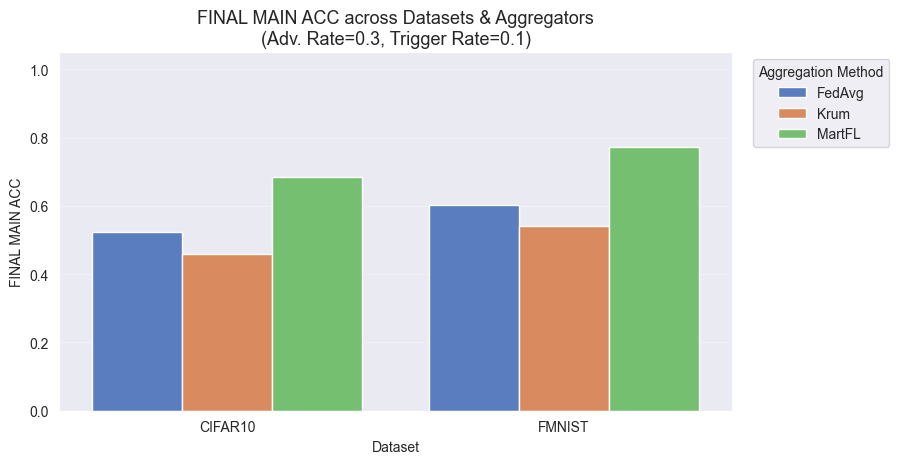

Saved bar chart: ./results/paper_figures/full_analysis/overview_bar_FINAL_ASR_adv0.3_trig0.1.pdf


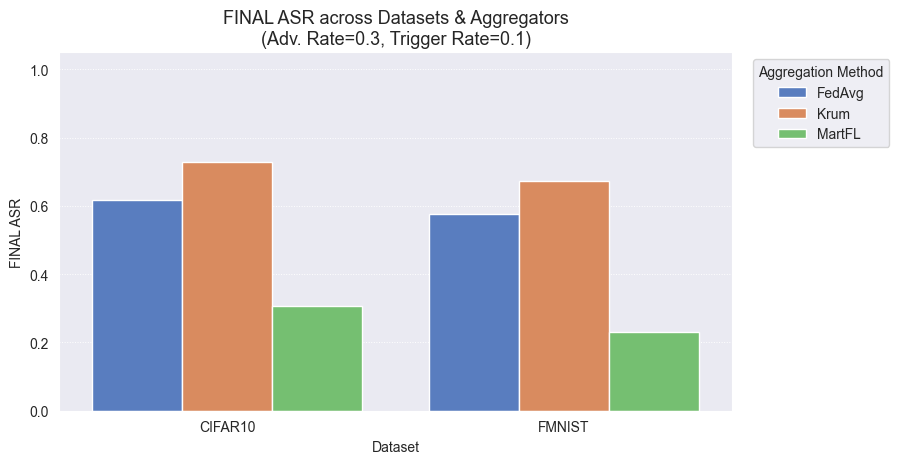


--- Generating Line Plots (Sensitivity to ADV_RATE) ---
Saved line plot: ./results/paper_figures/full_analysis/CIFAR10_line_FINAL_MAIN_ACC_vs_adv_rate_trig0.1.pdf


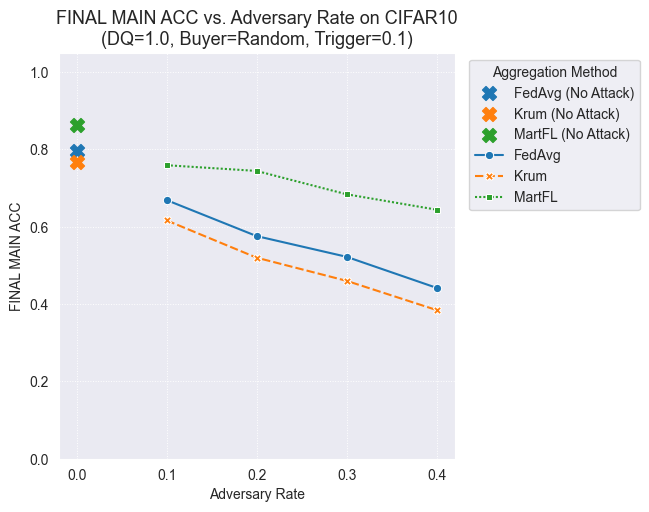

Saved line plot: ./results/paper_figures/full_analysis/CIFAR10_line_FINAL_ASR_vs_adv_rate_trig0.1.pdf


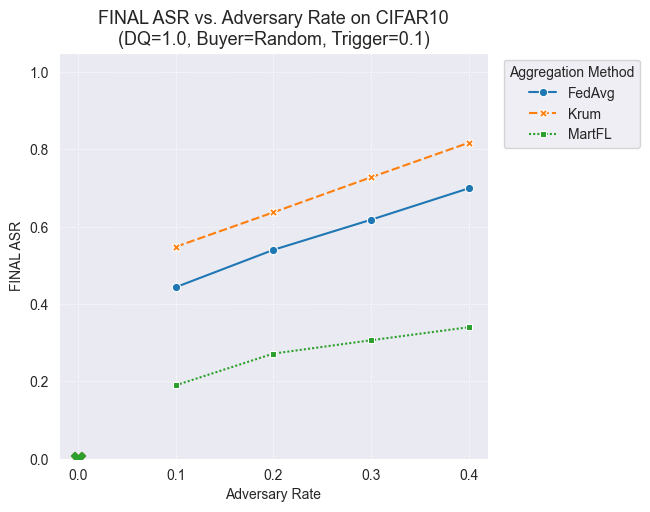

Saved line plot: ./results/paper_figures/full_analysis/CIFAR10_line_AVG_ADVERSARY_SELECTION_RATE_vs_adv_rate_trig0.1.pdf


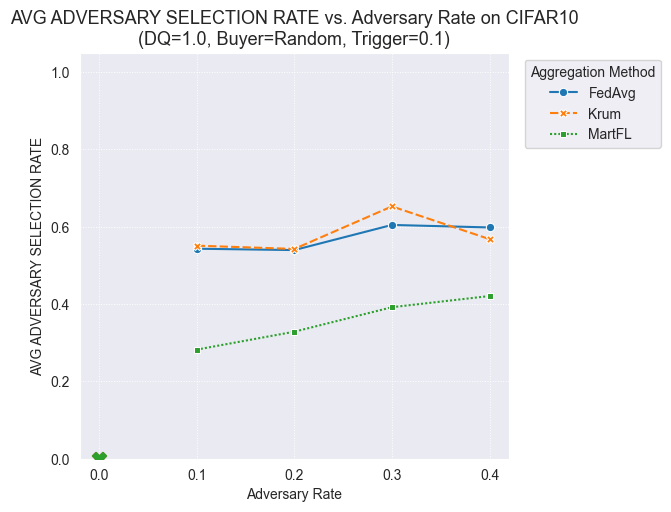

Saved line plot: ./results/paper_figures/full_analysis/FMNIST_line_FINAL_MAIN_ACC_vs_adv_rate_trig0.1.pdf


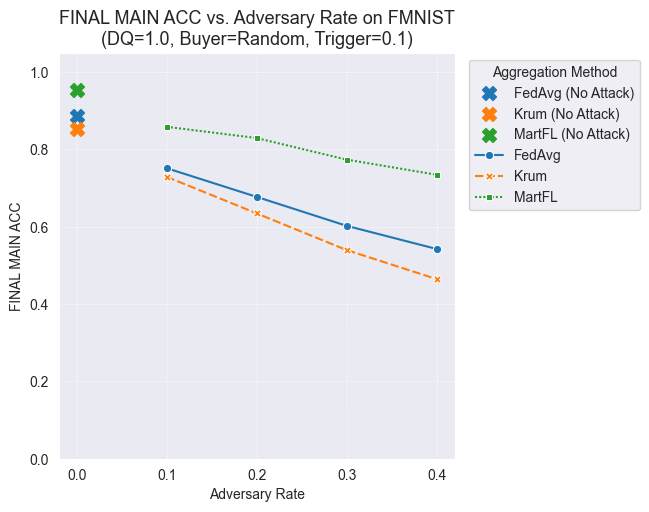

Saved line plot: ./results/paper_figures/full_analysis/FMNIST_line_FINAL_ASR_vs_adv_rate_trig0.1.pdf


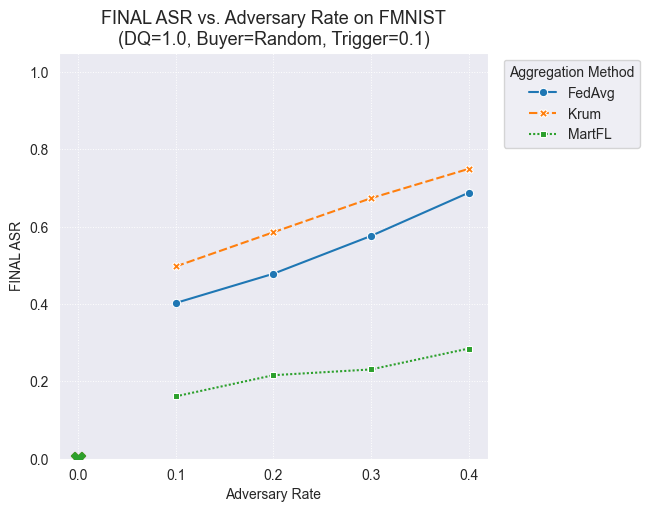

Saved line plot: ./results/paper_figures/full_analysis/FMNIST_line_AVG_ADVERSARY_SELECTION_RATE_vs_adv_rate_trig0.1.pdf


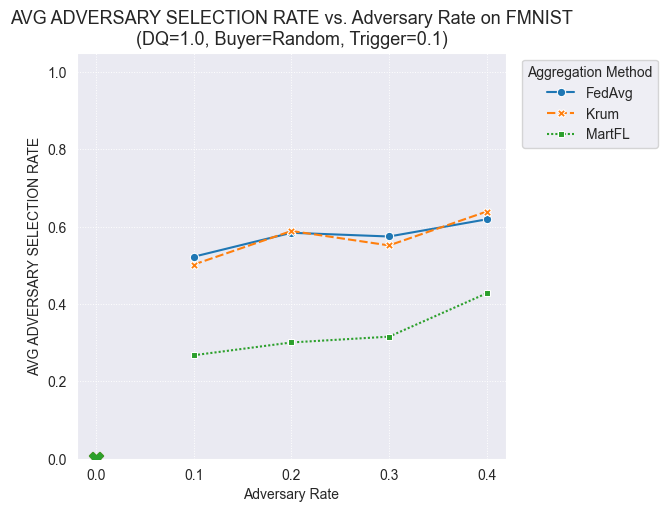


--- Full Analysis Plot Generation Complete ---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# --- Configuration ---
# Ensure these match your DataFrame's unique values
# DATASETS_TO_ANALYZE = sorted(summary_df_avg['DATASET'].unique()) # Detect dynamically
# AGGREGATION_METHODS_TO_ANALYZE = sorted(summary_df_avg['AGGREGATION_METHOD'].unique()) # Detect dynamically
YOUR_PRIMARY_BACKDOOR_ATTACK_NAME = 'Backdoor' # The main attack to focus on

# Fixed parameters for some overview plots (ADJUST AS NEEDED)
FIXED_ADV_RATE_FOR_OVERVIEW = 0.3 # A challenging adversary rate for bar chart comparisons
FIXED_DISCOVERY_QUALITY_OVERVIEW = 1.0
FIXED_BUYER_MODE_OVERVIEW = 'random'
FIXED_TRIGGER_RATE_OVERVIEW = 0.1 # Or your relevant fixed trigger rate

# For line plots (ADV_RATE on X-axis)
ADV_RATES_X_AXIS = sorted([0.1, 0.2, 0.3, 0.4]) # Or detect from data if more varied

# --- Output Paths ---
BASE_SAVE_DIR_FULL_ANALYSIS = "./results/paper_figures/full_analysis/"
os.makedirs(BASE_SAVE_DIR_FULL_ANALYSIS, exist_ok=True)

# --- Dummy Data for Testing (if summary_df_avg is not available) ---
if 'summary_df_avg' not in locals() or summary_df_avg.empty:
    print("CRITICAL ERROR: 'summary_df_avg' DataFrame not found. Using dummy data.")
    dummy_data_list_full = []
    datasets_dummy = ['FMNIST', 'CIFAR10']
    aggregators_dummy = ['MartFL', 'FedAvg', 'Krum']
    adv_rates_dummy_line = ADV_RATES_X_AXIS
    trigger_rates_dummy_fixed = [FIXED_TRIGGER_RATE_OVERVIEW]

    for ds in datasets_dummy:
        for agg in aggregators_dummy:
            for adv_rate_line in adv_rates_dummy_line: # For line plots
                 for run_seed in range(3): # 3 runs per setting
                    acc_base = 0.9 if agg == 'MartFL' else (0.85 if agg == 'FedAvg' else 0.8)
                    asr_base = 0.1 if agg == 'MartFL' else (0.3 if agg == 'FedAvg' else 0.4)
                    if ds == 'CIFAR10':
                        acc_base -= 0.1
                        asr_base += 0.05
                    dummy_data_list_full.append({
                        'DATASET': ds, 'AGGREGATION_METHOD': agg, 'ATTACK_METHOD': YOUR_PRIMARY_BACKDOOR_ATTACK_NAME,
                        'ADV_RATE': adv_rate_line, 'discovery_quality': FIXED_DISCOVERY_QUALITY_OVERVIEW,
                        'buyer_data_mode': FIXED_BUYER_MODE_OVERVIEW, 'TRIGGER_RATE': FIXED_TRIGGER_RATE_OVERVIEW,
                        'FINAL_MAIN_ACC': max(0, acc_base - adv_rate_line * (0.8 if agg != 'MartFL' else 0.4) + np.random.normal(0,0.02)),
                        'FINAL_ASR': min(1, asr_base + adv_rate_line * (0.9 if agg != 'MartFL' else 0.5) + np.random.normal(0,0.03)),
                        'AVG_ADVERSARY_SELECTION_RATE': min(1, (0.2 + adv_rate_line * 0.5 if agg == 'MartFL' else 0.5 + adv_rate_line*0.3) + np.random.normal(0,0.05))
                    })
            # Add 'No Attack' data for baseline
            dummy_data_list_full.append({
                'DATASET': ds, 'AGGREGATION_METHOD': agg, 'ATTACK_METHOD': 'No Attack',
                'ADV_RATE': 0.0, 'discovery_quality': FIXED_DISCOVERY_QUALITY_OVERVIEW,
                'buyer_data_mode': FIXED_BUYER_MODE_OVERVIEW, 'TRIGGER_RATE': 0.0, # Trigger rate usually 0 for no attack
                'FINAL_MAIN_ACC': acc_base + 0.05 + np.random.normal(0,0.01), 'FINAL_ASR': 0.0,
                'AVG_ADVERSARY_SELECTION_RATE': 0.0
            })
    summary_df_avg = pd.DataFrame(dummy_data_list_full)
    summary_df_avg['FINAL_MAIN_ACC'] = summary_df_avg['FINAL_MAIN_ACC'].clip(0,1)
    summary_df_avg['FINAL_ASR'] = summary_df_avg['FINAL_ASR'].clip(0,1)
    summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'] = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].clip(0,1)
else:
    print("'summary_df_avg' DataFrame is available.")

# Dynamically get unique datasets and aggregation methods if not hardcoded
DATASETS_TO_ANALYZE = sorted(summary_df_avg['DATASET'].unique())
AGGREGATION_METHODS_TO_ANALYZE = sorted(summary_df_avg['AGGREGATION_METHOD'].unique())
print(f"Analyzing Datasets: {DATASETS_TO_ANALYZE}")
print(f"Analyzing Aggregation Methods: {AGGREGATION_METHODS_TO_ANALYZE}")


# --- Helper function for grouping and averaging (reusable) ---
def get_averaged_data_multi(df, group_by_cols, metrics_to_avg):
    if df.empty: return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    actual_metrics_to_avg = [m for m in metrics_to_avg if m in df.columns]
    if not actual_metrics_to_avg: return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    
    # Store original dtypes for group_by_cols
    original_dtypes = {col: df[col].dtype for col in group_by_cols if col in df.columns}

    df_cleaned = df.dropna(subset=actual_metrics_to_avg, how='any').copy()
    if df_cleaned.empty: return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    
    for metric in actual_metrics_to_avg: # Ensure metrics are numeric
        df_cleaned[metric] = pd.to_numeric(df_cleaned[metric], errors='coerce')
    df_cleaned.dropna(subset=actual_metrics_to_avg, how='any', inplace=True) # Drop if coerce made NaNs
    
    if df_cleaned.empty: return pd.DataFrame(columns=group_by_cols + metrics_to_avg)
    
    averaged_df = df_cleaned.groupby(group_by_cols, as_index=False, observed=True)[actual_metrics_to_avg].mean() # observed=True for categoricals

    # Restore original dtypes for group_by_cols if they were changed by groupby
    for col, dtype in original_dtypes.items():
        if col in averaged_df.columns and averaged_df[col].dtype != dtype:
            try:
                averaged_df[col] = averaged_df[col].astype(dtype)
            except Exception as e:
                print(f"Could not restore dtype for {col}: {e}")

    return averaged_df


# --- PLOT TYPE 1: Overview Bar Charts (ACC & ASR at fixed ADV_RATE) ---
print("\n--- Generating Overview Bar Charts ---")
metrics_for_bar = ['FINAL_MAIN_ACC', 'FINAL_ASR']

# Filter data for these bar charts
bar_chart_filter_conditions = (
    (summary_df_avg['ATTACK_METHOD'] == YOUR_PRIMARY_BACKDOOR_ATTACK_NAME) &
    (summary_df_avg['ADV_RATE'] == FIXED_ADV_RATE_FOR_OVERVIEW) &
    (summary_df_avg['discovery_quality'] == FIXED_DISCOVERY_QUALITY_OVERVIEW) &
    (summary_df_avg['buyer_data_mode'] == FIXED_BUYER_MODE_OVERVIEW) &
    (summary_df_avg['TRIGGER_RATE'] == FIXED_TRIGGER_RATE_OVERVIEW) &
    (summary_df_avg['DATASET'].isin(DATASETS_TO_ANALYZE)) &
    (summary_df_avg['AGGREGATION_METHOD'].isin(AGGREGATION_METHODS_TO_ANALYZE))
)
df_for_bar_charts_raw = summary_df_avg[bar_chart_filter_conditions].copy()

# Average over any remaining variations (e.g., seeds)
df_for_bar_charts_avg = get_averaged_data_multi(
    df_for_bar_charts_raw,
    group_by_cols=['DATASET', 'AGGREGATION_METHOD'], # These are the primary groups for the bars
    metrics_to_avg=metrics_for_bar
)

if not df_for_bar_charts_avg.empty:
    for metric in metrics_for_bar:
        if metric not in df_for_bar_charts_avg.columns:
            print(f"Metric {metric} not found in averaged data for bar charts. Skipping.")
            continue
        
        plt.figure(figsize=(7 + 0.7 * len(AGGREGATION_METHODS_TO_ANALYZE), 5)) # Adjust width
        sns.barplot(
            x='DATASET',
            y=metric,
            hue='AGGREGATION_METHOD',
            data=df_for_bar_charts_avg,
            palette='muted',
            hue_order=AGGREGATION_METHODS_TO_ANALYZE # Ensure consistent legend order
        )
        plt.title(f'{metric.replace("_", " ")} across Datasets & Aggregators\n(Adv. Rate={FIXED_ADV_RATE_FOR_OVERVIEW}, Trigger Rate={FIXED_TRIGGER_RATE_OVERVIEW})', fontsize=13)
        plt.ylabel(metric.replace("_", " "))
        plt.xlabel('Dataset')
        plt.xticks(rotation=0, ha='center')
        plt.legend(title='Aggregation Method', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.ylim(0, 1.05 if 'ACC' in metric or 'ASR' in metric else None)
        plt.grid(axis='y', linestyle=':', linewidth=0.7)
        plt.tight_layout(rect=[0, 0, 0.85 if len(AGGREGATION_METHODS_TO_ANALYZE) > 3 else 1, 0.95]) # Adjust for legend

        filename_bar = f"{BASE_SAVE_DIR_FULL_ANALYSIS}overview_bar_{metric}_adv{FIXED_ADV_RATE_FOR_OVERVIEW}_trig{FIXED_TRIGGER_RATE_OVERVIEW}.pdf"
        try:
            plt.savefig(filename_bar, bbox_inches='tight', dpi=300)
            print(f"Saved bar chart: {filename_bar}")
        except Exception as e:
            print(f"Error saving bar chart {filename_bar}: {e}")
        plt.show()
else:
    print("Warning: No data available for overview bar charts after filtering and averaging.")


# --- PLOT TYPE 2: Line Plots (Sensitivity to ADV_RATE) ---
print("\n--- Generating Line Plots (Sensitivity to ADV_RATE) ---")
metrics_for_line = ['FINAL_MAIN_ACC', 'FINAL_ASR', 'AVG_ADVERSARY_SELECTION_RATE']

# Filter data for these line plots (fixed DQ, BuyerMode, TriggerRate)
line_plot_filter_conditions = (
    # ATTACK_METHOD can be Backdoor or No Attack (for baseline)
    (summary_df_avg['ATTACK_METHOD'].isin([YOUR_PRIMARY_BACKDOOR_ATTACK_NAME, 'No Attack'])) &
    (summary_df_avg['discovery_quality'] == FIXED_DISCOVERY_QUALITY_OVERVIEW) &
    (summary_df_avg['buyer_data_mode'] == FIXED_BUYER_MODE_OVERVIEW) &
    # For 'No Attack', TRIGGER_RATE is often 0. For attacks, it's your fixed value.
    ( (summary_df_avg['ATTACK_METHOD'] == 'No Attack') & (summary_df_avg['TRIGGER_RATE'] == 0.0) |
      (summary_df_avg['ATTACK_METHOD'] == YOUR_PRIMARY_BACKDOOR_ATTACK_NAME) & (summary_df_avg['TRIGGER_RATE'] == FIXED_TRIGGER_RATE_OVERVIEW) ) &
    (summary_df_avg['DATASET'].isin(DATASETS_TO_ANALYZE)) &
    (summary_df_avg['AGGREGATION_METHOD'].isin(AGGREGATION_METHODS_TO_ANALYZE)) &
    ( # ADV_RATE conditions: 0.0 for No Attack, or in ADV_RATES_X_AXIS for active attacks
        (summary_df_avg['ATTACK_METHOD'] == 'No Attack' ) & (summary_df_avg['ADV_RATE'] == 0.0) |
        (summary_df_avg['ATTACK_METHOD'] == YOUR_PRIMARY_BACKDOOR_ATTACK_NAME ) & (summary_df_avg['ADV_RATE'].isin(ADV_RATES_X_AXIS))
    )
)
df_for_line_plots_raw = summary_df_avg[line_plot_filter_conditions].copy()

# Average over any remaining variations (e.g., seeds)
df_for_line_plots_avg = get_averaged_data_multi(
    df_for_line_plots_raw,
    group_by_cols=['DATASET', 'AGGREGATION_METHOD', 'ATTACK_METHOD', 'ADV_RATE'],
    metrics_to_avg=metrics_for_line
)

if not df_for_line_plots_avg.empty:
    for dataset in DATASETS_TO_ANALYZE:
        df_dataset_lines = df_for_line_plots_avg[df_for_line_plots_avg['DATASET'] == dataset]
        if df_dataset_lines.empty:
            print(f"No data for line plots for dataset: {dataset}")
            continue

        for metric in metrics_for_line:
            if metric not in df_dataset_lines.columns:
                print(f"Metric {metric} not found for line plots for dataset: {dataset}. Skipping.")
                continue

            plt.figure(figsize=(8, 5.5))
            
            # Use a good color palette for aggregators
            line_palette = sns.color_palette("tab10", n_colors=len(AGGREGATION_METHODS_TO_ANALYZE))
            agg_color_map = {agg: line_palette[i] for i, agg in enumerate(AGGREGATION_METHODS_TO_ANALYZE)}

            # Plot 'No Attack' baseline first if present (as points)
            df_no_attack_baseline = df_dataset_lines[
                (df_dataset_lines['ATTACK_METHOD'] == 'No Attack') &
                (df_dataset_lines['ADV_RATE'] == 0.0)
            ]
            if not df_no_attack_baseline.empty:
                for agg_method in AGGREGATION_METHODS_TO_ANALYZE:
                    data_no_attack_agg = df_no_attack_baseline[df_no_attack_baseline['AGGREGATION_METHOD'] == agg_method]
                    if not data_no_attack_agg.empty and metric in data_no_attack_agg.columns:
                        plt.scatter(
                            data_no_attack_agg['ADV_RATE'], data_no_attack_agg[metric],
                            color=agg_color_map.get(agg_method, 'gray'), marker='X', s=100, zorder=5,
                            label=f'{agg_method} (No Attack)' if metric == 'FINAL_MAIN_ACC' else None # Avoid duplicate legend for ASR/SelRate
                        )
            
            # Plot lines for active attack
            df_active_attack_lines = df_dataset_lines[df_dataset_lines['ATTACK_METHOD'] == YOUR_PRIMARY_BACKDOOR_ATTACK_NAME]
            if not df_active_attack_lines.empty:
                sns.lineplot(
                    x='ADV_RATE',
                    y=metric,
                    hue='AGGREGATION_METHOD',
                    hue_order=AGGREGATION_METHODS_TO_ANALYZE, # Consistent legend
                    style='AGGREGATION_METHOD', # Different linestyles
                    style_order=AGGREGATION_METHODS_TO_ANALYZE,
                    markers=True, # Add markers
                    data=df_active_attack_lines,
                    palette=agg_color_map,
                    errorbar=None # Data is already averaged
                )

            plt.title(f'{metric.replace("_", " ")} vs. Adversary Rate on {dataset}\n(DQ={FIXED_DISCOVERY_QUALITY_OVERVIEW}, Buyer={FIXED_BUYER_MODE_OVERVIEW.capitalize()}, Trigger={FIXED_TRIGGER_RATE_OVERVIEW})', fontsize=13)
            plt.xlabel('Adversary Rate')
            plt.ylabel(metric.replace("_", " "))
            plt.ylim(0, 1.05 if 'ACC' in metric or 'ASR' in metric or 'RATE' in metric else None)
            plt.xticks(ADV_RATES_X_AXIS + [0.0] if 0.0 not in ADV_RATES_X_AXIS else ADV_RATES_X_AXIS) # Ensure 0.0 is a tick
            plt.grid(True, linestyle=':', linewidth=0.7)

            # Consolidate legend if No Attack points were plotted
            handles, labels = plt.gca().get_legend_handles_labels()
            # Remove "AGGREGATION_METHOD" title from legend if seaborn adds it
            if labels and labels[0] == 'AGGREGATION_METHOD':
                handles = handles[1:]
                labels = labels[1:]
            
            # Create a cleaner legend if No Attack points were plotted
            # This is a bit complex to get perfect, seaborn sometimes makes it tricky with scatter + line
            unique_labels = {}
            final_handles = []
            final_labels = []
            for handle, label in zip(handles, labels):
                if label not in unique_labels:
                    unique_labels[label] = handle
                    final_handles.append(handle)
                    final_labels.append(label)

            if final_handles:
                 plt.legend(handles=final_handles, labels=final_labels, title='Aggregation Method', bbox_to_anchor=(1.02, 1), loc='upper left')
            
            plt.tight_layout(rect=[0, 0, 0.83 if len(AGGREGATION_METHODS_TO_ANALYZE)>2 else 1, 0.95])

            filename_line = f"{BASE_SAVE_DIR_FULL_ANALYSIS}{dataset}_line_{metric}_vs_adv_rate_trig{FIXED_TRIGGER_RATE_OVERVIEW}.pdf"
            try:
                plt.savefig(filename_line, bbox_inches='tight', dpi=300)
                print(f"Saved line plot: {filename_line}")
            except Exception as e:
                print(f"Error saving line plot {filename_line}: {e}")
            plt.show()
else:
    print("Warning: No data available for line plots after filtering and averaging.")

print("\n--- Full Analysis Plot Generation Complete ---")